# Шаг 1. Получение и парсинг данных

In [37]:
import requests
from bs4 import BeautifulSoup
from bs4.element import Comment
import pandas as pd
import datetime
import warnings
warnings.filterwarnings("ignore")

In [39]:
cookies = {
    '__ddg1_': 'peYZRM5tlNWPgugd940V',
    '__ddg9_': '92.243.182.237',
    '_ym_uid': '1715004481699210864',
    '_ym_d': '1730388353',
    '_ym_isad': '1',
    '_ym_visorc': 'w',
    'accept': '1',
    'ASPNET_SessionID': 'haizcalavgerqkaig0w12awe',
    '__ddg10_': '1730388981',
    '__ddg8_': 'jrQSy3NYA2gFDIsY',
}

In [41]:
headers = {
    'accept': 'text/html, */*; q=0.01',
    'accept-language': 'ru-RU,ru;q=0.9,en-US;q=0.8,en;q=0.7',
    # 'cookie': '__ddg1_=peYZRM5tlNWPgugd940V; __ddg9_=92.243.182.237; _ym_uid=1715004481699210864; _ym_d=1730388353; _ym_isad=1; _ym_visorc=w; accept=1; ASPNET_SessionID=haizcalavgerqkaig0w12awe; __ddg10_=1730388981; __ddg8_=jrQSy3NYA2gFDIsY',
    'priority': 'u=1, i',
    'referer': 'https://www.cbr.ru/dkp/mp_dec/',
    'sec-ch-ua': '"Chromium";v="130", "Google Chrome";v="130", "Not?A_Brand";v="99"',
    'sec-ch-ua-mobile': '?0',
    'sec-ch-ua-platform': '"macOS"',
    'sec-fetch-dest': 'empty',
    'sec-fetch-mode': 'cors',
    'sec-fetch-site': 'same-origin',
    'user-agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/130.0.0.0 Safari/537.36',
    'x-requested-with': 'XMLHttpRequest',
}


In [43]:
press_list = []
load_more_url = 'https://www.cbr.ru/Crosscut/NewsList/LoadMore/84035'
press_release_links = []

offset = 0
max_offset = 200

while offset < max_offset:
    params = {
        'intOffset': '0',
        'extOffset': str(offset),
    }
    response = requests.get(load_more_url, params=params)
    soup = BeautifulSoup(response.text, 'html.parser')
    hrefs = soup.find_all("div", {"class": "previews_item-title"})

    for href in hrefs:
        a_tag = href.find('a', href=True)
        if a_tag and a_tag['href'] not in press_release_links:
            press_release_links.append(a_tag['href'])

    offset += 10

for url in press_release_links:
    print('opening...' + url)
    response = requests.get('https://www.cbr.ru/' + url)
    bs = BeautifulSoup(response.text, 'html.parser')
    date = bs.find("div",{'class': 'col-md-6 col-12 news-info-line_date'}).get_text()
    text = bs.find_all("div", {"class": "landing-text"})
    press_list.append([date, text[0].get_text()])

opening.../press/pr/?file=20122024_133000key.htm
opening.../press/pr/?file=25102024_133000Key.htm
opening.../press/pr/?file=13092024_133000Key.htm
opening.../press/pr/?file=26072024_133000Key.htm
opening.../press/pr/?file=07062024_133000Key.htm
opening.../press/pr/?file=26042024_133000key.htm
opening.../press/pr/?file=22032024_133000key.htm
opening.../press/pr/?file=16022024_133000key.htm
opening.../press/pr/?file=15122023_133000key.htm
opening.../press/pr/?file=27102023_133000key.htm
opening.../press/pr/?file=15092023_133000Key.htm
opening.../press/pr/?file=15082023_103000Key.htm
opening.../press/pr/?file=21072023_133000Key.htm
opening.../press/pr/?file=09062023_133024Key.htm
opening.../press/pr/?file=28042023_133000Key.htm
opening.../press/pr/?file=17032023_133000Key.htm
opening.../press/pr/?file=10022023_133000Key.htm
opening.../press/pr/?file=16122022_133000Key.htm
opening.../press/pr/?file=28102022_133000Key.htm
opening.../press/pr/?file=16092022_133000Key.htm
opening.../press/pr/

In [47]:
# формирование датафрейма
row_data = pd.DataFrame(press_list, columns = ['date', 'text'])
row_data = row_data.drop_duplicates()
row_data

,date,text
0,20 декабря 2024 года,\n \nСовет директоров Банка России 20 декабря ...
1,25 октября 2024 года,\n \nСовет директоров Банка России 25 октября ...
2,13 сентября 2024 года,\n \nСовет директоров Банка России 13 сентября...
3,26 июля 2024 года,\n \nСовет директоров Банка России 26 июля 202...
4,7 июня 2024 года,\n \nСовет директоров Банка России 7 июня 2024...
...,...,...
97,13 декабря 2013 года,\nСовет директоров Банка России 13 декабря 201...
98,8 ноября 2013 года,\nСовет директоров Банка России 8 ноября 2013 ...
99,14 октября 2013 года,"\nПресс-служба Банка России сообщает, что Сове..."
100,13 сентября 2013 года,\n О системе процентных инструментов денежно...


In [49]:
# чистим от лишних символов
def edit(df, column_name):
    df[column_name] = df[column_name].replace('\xa0', ' ', regex=True)
    df[column_name] = df[column_name].replace(r'\n', '', regex=True)
    df[column_name] = df[column_name].replace('_x000D_', '', regex=True)
    df[column_name] = df[column_name].replace('\r', ' ', regex=True)
    df[column_name] = df[column_name].apply(lambda x: x.strip())
    df[column_name] = df[column_name].replace('  ', ' ', regex=True)

    return df

edited_data = edit(row_data, 'text')

In [51]:
# убираем неинформативные пресс-релизы
import re

def remove_trash(df, column_name):

    mask = ~(df[column_name].str.contains("Банк России, следуя наилучшим практикам распространения данных", na=False) |
             df[column_name].str.contains("целях оперативного информирования пользователей", na=False) |
             df[column_name].str.contains("Банк России начинает публиковать на", na=False))

    filtered_df = df[mask]

    return filtered_df

filtered_df = remove_trash(edited_data, 'text')

In [53]:
# парсим дату
def parse_date(df, column_name):

    month_dict = {
        "января": 1, "февраля": 2, "марта": 3, "апреля": 4, "мая": 5, "июня": 6,
        "июля": 7, "августа": 8, "сентября": 9, "октября": 10, "ноября": 11,
        "декабря": 12
    }

    def extract_date_parts(date_str):
        try:
            match = re.match(r"(\d{1,2})\s+([а-я]+)\s+(\d{4})\s+года", date_str)
            if match:
                day = int(match.group(1))
                month = month_dict[match.group(2)]
                year = int(match.group(3))
                return year, month, day
            else:
                return None, None, None
        except (KeyError, AttributeError, ValueError):
            return None, None, None


    df[["year", "month", "day"]] = df[column_name].apply(
        lambda x: pd.Series(extract_date_parts(x))
    )

    return df.drop(columns=column_name)

df = parse_date(filtered_df, 'date')

In [55]:
# формируем колонку target
def classify_key_rate_change_df(df, column_name):

    target_values = []

    for text in df[column_name]:
        match = re.search(r"(повысить|понизить|снизить|сохранить|оставить)\s+(ключевую|процентную)\s+ставку", text.lower())
        if match:
            action = match.group(1)
            if action == "повысить":
                target_values.append(1)
            elif action == "понизить" or action == "снизить":
                target_values.append(-1)
            elif action == "сохранить" or action == "оставить":
                target_values.append(0)
        else:
            target_values.append("Не найдено")

    df['target'] = target_values
    return df


df = classify_key_rate_change_df(df, 'text')

In [57]:
df.reset_index(inplace=True)

In [59]:
df[df['target'] == 'Не найдено']

,index,text,year,month,day,target
84,87,Совет директоров Банка России принял решение п...,2014,12,16,Не найдено
97,100,О системе процентных инструментов денежно-кред...,2013,9,13,Не найдено


In [61]:
df.loc[97]['text']

'О системе процентных инструментов денежно-кредитной политики Банка России  Департамент внешних и общественных связей Банка России сообщает, что 13 сентября 2013 года Совет директоров Банка России в рамках перехода к режиму таргетирования инфляции принял решение о реализации комплекса мер по совершенствованию системы инструментов денежно-кредитной политики. Данные меры включают: 1) введение ключевой ставки Банка России путем унификации процентных ставок по операциям предоставления и абсорбирования ликвидности на аукционной основе на срок 1 неделя; 2) формирование коридора процентных ставок Банка России и оптимизацию системы инструментов по регулированию ликвидности банковского сектора; 3) изменение роли ставки рефинансирования в системе инструментов Банка России. Указанные мероприятия позволят повысить прозрачность денежно-кредитной политики и улучшить ее понимание субъектами экономики, что будет способствовать усилению действенности процентного и информационного каналов трансмиссионно

In [63]:
df.loc[84]['text']

'Совет директоров Банка России принял решение повысить с 16 декабря 2014 года ключевую ставку до 17,00% годовых. Данное решение обусловлено необходимостью ограничить существенно возросшие в последнее время девальвационные и инфляционные риски. В целях усиления действенности процентной политики кредиты, обеспеченные нерыночными активами или поручительствами, на срок от 2 до 549 дней с 16 декабря 2014 года будут предоставляться по плавающей процентной ставке, установленной на уровне ключевой ставки Банка России, увеличенной на 1,75 п.п. (ранее данные кредиты на срок от 2 до 90 дней предоставлялись по фиксированной ставке).Кроме того, для расширения возможностей кредитных организаций по управлению собственной валютной ликвидностью было принято решение об увеличении максимального объема предоставления средств на аукционах РЕПО в иностранной валюте на срок 28 дней с 1,5 до 5,0 млрд. долларов США, а также о проведении аналогичных операций на срок 12 месяцев на еженедельной основе. Процентные

In [65]:
df.loc[84, ['target']] = 1
df = df.drop(97).reset_index(drop=True)
df

,index,text,year,month,day,target
0,0,Совет директоров Банка России 20 декабря 2024 ...,2024,12,20,0
1,1,Совет директоров Банка России 25 октября 2024 ...,2024,10,25,1
2,2,Совет директоров Банка России 13 сентября 2024...,2024,9,13,1
3,3,Совет директоров Банка России 26 июля 2024 год...,2024,7,26,1
4,4,Совет директоров Банка России 7 июня 2024 года...,2024,6,7,0
...,...,...,...,...,...,...
93,96,Совет директоров Банка России 14 февраля 2014 ...,2014,2,14,0
94,97,Совет директоров Банка России 13 декабря 2013 ...,2013,12,13,0
95,98,Совет директоров Банка России 8 ноября 2013 го...,2013,11,8,0
96,99,"Пресс-служба Банка России сообщает, что Совет ...",2013,10,14,0


In [67]:
import numpy as np
df['target'] = df['target'].shift(1)
df.loc[0, ['target']] = np.nan
df = df.drop(columns='index')
df.head()

,text,year,month,day,target
0,Совет директоров Банка России 20 декабря 2024 ...,2024,12,20,NaN
1,Совет директоров Банка России 25 октября 2024 ...,2024,10,25,0
2,Совет директоров Банка России 13 сентября 2024...,2024,9,13,1
3,Совет директоров Банка России 26 июля 2024 год...,2024,7,26,1
4,Совет директоров Банка России 7 июня 2024 года...,2024,6,7,1


In [69]:
wonder = df.loc[0]
wonder



text      Совет директоров Банка России 20 декабря 2024 ...
year                                                   2024
month                                                    12
day                                                      20
target                                                  NaN
Name: 0, dtype: object

In [71]:
df = df.drop(0).reset_index(drop=True)
df.head()

,text,year,month,day,target
0,Совет директоров Банка России 25 октября 2024 ...,2024,10,25,0
1,Совет директоров Банка России 13 сентября 2024...,2024,9,13,1
2,Совет директоров Банка России 26 июля 2024 год...,2024,7,26,1
3,Совет директоров Банка России 7 июня 2024 года...,2024,6,7,1
4,Совет директоров Банка России 26 апреля 2024 г...,2024,4,26,0


In [73]:
df.target.value_counts()

target
0     42
-1    30
1     25
Name: count, dtype: int64

In [75]:
df.shape

(97, 5)

In [77]:
df.to_excel('dataset.xlsx')

In [79]:
wonder.to_excel('wonder.xlsx')


## Итог шага 1: сформирован датафрейм из 97 строк. Датафрейм имеет следующие колонки:
- year
- month
- day
- text
- target (1 - ставка повысилась, 0 - ставка не изменилась, -1 - ставка понизилась)

# Шаг 2. Разведочный анализ данных (NLP)

## 1. Провести анализ текстов:
1. Изучаем данные, ищем и чистим мусор, заводим столбец с датой пресс-релиза
2. Расчет средней, минимальной и максимальной длины текстов (визуализация распределения),
3. Частотный анализ слов и n-грамм, извлечение биграмм и триграмм, статистики посимволам и словам, распределение частей речи.

## 1.1. Изучаем данные, ищем и чистим мусор, заводим столбец с датой пресс-релиза

In [85]:
from string import punctuation
import nltk
punctuation
nltk.download("stopwords", quiet=True)
from nltk.corpus import stopwords
noise = stopwords.words("russian") + list(punctuation)

In [86]:
df['text'][1][:200]

'Совет директоров Банка России 13 сентября 2024 года принял решение повысить ключевую ставку на 100 б.п., до 19,00% годовых. Текущее инфляционное давление остается высоким. Годовая инфляция по итогам 2'

### По результатам анализа текстов пресс релиза чистим мусор.

Отрезаем снизу, начиная с паттерна:
Паттерн 1 —
6 ноября 2024 года Банк России опубликует Резюме обсуждения ключевой ставки …

1 апреля 2024 года Банк России опубликует Резюме обсуждения …

27 февраля 2024 года Банк России опубликует Резюме обсуждения ключевой ставки …


Паттерн 2 (если нет паттерна 1 в конце пресс релиза) —

Следующее заседание Совета директоров Банка России …

In [90]:
df['text'][1][3800:]

'итики, так и принятые ранее макропруденциальные меры. Вместе с тем темпы роста корпоративного кредитования пока остаются повышенными из-за значимого вклада менее чувствительных к рыночным ставкам операций. Принятое Банком России решение ускорит формирование денежно-кредитных условий, необходимых для роста сберегательной активности и возвращения кредитования к сбалансированному росту.На среднесрочном горизонте баланс рисков для инфляции существенно смещен в сторону проинфляционных. Увеличились проинфляционные риски, связанные с ухудшением условий внешней торговли. Также остаются риски, связанные с сохранением высоких инфляционных ожиданий и отклонения российской экономики вверх от траектории сбалансированного роста. Дезинфляционные риски в первую очередь связаны с более быстрым замедлением роста внутреннего спроса, чем ожидается в базовом сценарии.Банк России исходит из неизменности объявленной траектории нормализации бюджетной политики в 2024 году и последующие годы. Изменения в бюдже

In [92]:
def cut_bottom(row):
    origin = row['text']
    row = row['text'].lower()
    pattern_1 = r'(?<=\.)[^\.]*\d{1,2}[^\.]+банк\s*россии\s*опубликует\s*резюме'
    pattern_2 = r'(?<=\.)[^\.]*следующее\s*(плановое)?\s*заседание\s*совета\s*директоров\s*банка\s*россии'
    pattern_3 = r'(?<=\.)[^\.]*заявление\s*председателя\s*банка\s*россии\s*по\s*итогам\s*заседания\s*совета\s*директоров\s*банка\s*россии\s*состоится'
    pattern_4 = r'(?<=\.)[^\.]*процентные\s*ставки\s*по\s*основным\s*операциям\s*банка\s*россии'

    substr = re.search(pattern_1, row)
    if substr:
        return origin[0:substr.span()[0]].strip()
    else:
        substr = re.search(pattern_2, row)
        if substr:
            return origin[0:substr.span()[0]].strip()
        else:
            substr = re.search(pattern_3, row)
    if substr:
        return origin[0:substr.span()[0]].strip()
    else:
        substr = re.search(pattern_4, row)
    if substr:
        return origin[0:substr.span()[0]].strip()
    else:
        return origin.strip()

In [94]:
df['text']  = df.apply(lambda row: cut_bottom(row).strip(), axis = 1)

In [96]:
df['text'][90][3000:]

'ые факторы частично компенсируют эффект переноса динамики курса рубля на инфляцию. Однако риски превышения цели в 2014 году сохраняются.При текущей направленности денежно-кредитной политики снижение темпов роста потребительских цен возобновится во второй половине 2014 года, и в среднесрочной перспективе инфляция замедлится до целевых значений.'

### Отрезаем сверху (при наличии):
Новости О ключевой ставке Банка России 14 октября 2013  года Пресс-релиз Поделиться ВКонтакте WhatsApp Telegram

In [99]:
def cut_beg(row):
    origin = row['text']
    row = row['text'].lower()
    pattern = r'telegram'
    substr = re.search(pattern, row)
    if substr:
        return origin[substr.span()[1]+1:].strip()
    else:
        return origin.strip()

In [101]:
df['text']  = df.apply(lambda row: cut_beg(row).strip(), axis = 1)

In [103]:
df.shape

(97, 5)

## 1.2. Расчет средней, минимальной и максимальной длины текстов (визуализация распределения)

In [106]:
# добавляем столбец с длинной релизов
df['length_text']  = df.apply(lambda row: len(row['text']), axis = 1)

In [108]:
print(f'Средняя длина пресс-релиза: {int(df['length_text'].mean())}.')
print(f'Минимальная длина пресс-релиза: {int(df['length_text'].min())}.')
print(f'Максимальная длина пресс-релиза: {int(df['length_text'].max())}.')

Средняя длина пресс-релиза: 5694.
Минимальная длина пресс-релиза: 320.
Максимальная длина пресс-релиза: 9756.


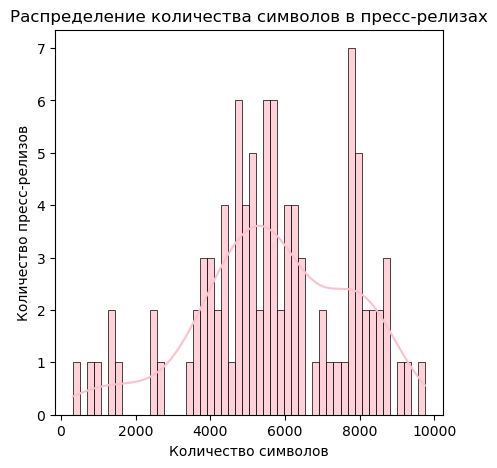

In [110]:
import matplotlib.pyplot as plt
import seaborn as sns

numeric_cols = ['length_text']

def draw_hist_plot(df, col):
    plt.figure(figsize = (5, 5))
    sns.histplot(data=df, x=col, bins=50, color='pink', kde=True, alpha=0.7)
    plt.title(f'Распределение количества символов в пресс-релизах')
    plt.xlabel(f'Количество символов')
    plt.ylabel(f'Количество пресс-релизов')
    plt.show()


for i in numeric_cols:
    draw_hist_plot(df, i)

## 1.3. Частотный анализ слов и n-грамм, извлечение биграмм и триграмм, статистики по символам и словам, распределение частей речи.

### Частотный анализ слов

In [114]:
import nltk
from nltk.tokenize import word_tokenize

In [116]:
nltk.download("punkt", quiet=True)

True

In [118]:
# токенизируем тексты (оставим только слова без пунктуации)
texts = df['text']
texts_tokenized = [" ".join([w for w in word_tokenize(t) if w.isalpha()]) for t in texts]

texts_tokenized[0][:300]

'Совет директоров Банка России октября года принял решение повысить ключевую ставку на до годовых Инфляция складывается существенно выше июльского прогноза Банка России Продолжают увеличиваться инфляционные ожидания Рост внутреннего спроса значительно опережает возможности расширения предложения това'

In [120]:
# лемматизируем тексты
from pymystem3 import Mystem

mystem_analyzer = Mystem()
texts_lemmatized = [mystem_analyzer.lemmatize(text) for text in texts_tokenized]
texts_lemmatized = [[j for j in i if j != ' ' and j != '\n'] for i in texts_lemmatized]

In [122]:
texts_lemmatized[0][:10]

['совет',
 'директор',
 'банк',
 'россия',
 'октябрь',
 'год',
 'принимать',
 'решение',
 'повышать',
 'ключевой']

In [124]:
texts_lemmatized = [" ".join([w for w in t]) for t in texts_lemmatized]

In [126]:
# мешок слов
from sklearn.feature_extraction.text import CountVectorizer

cnt_vec = CountVectorizer(stop_words='english')

X = cnt_vec.fit_transform(texts_lemmatized)

In [128]:
x = cnt_vec.vocabulary_
res = dict(sorted(x.items(), key=lambda item: item[1]))
#res.keys()

In [130]:
X.toarray()

array([[0, 0, 0, ..., 0, 0, 0],
       [2, 0, 0, ..., 0, 0, 0],
       [4, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 2, 0],
       [0, 0, 0, ..., 0, 2, 0],
       [0, 0, 0, ..., 0, 2, 0]])

In [132]:
bag_of_words = pd.DataFrame(X.toarray(), columns=res.keys())
bag_of_words

,ii,iii,iv,urals,абсорбирование,август,автомобиль,агент,аграрный,агрегат,...,эпидемия,эпизод,этап,это,этот,эффект,эффективность,юридический,являться,январь
0,0,0,0,0,0,2,0,0,0,0,...,0,0,0,3,1,1,0,0,0,0
1,2,0,0,0,0,3,0,1,0,0,...,0,0,0,2,2,1,0,0,0,0
2,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,3,0,0,0,0,0
3,1,0,0,0,0,0,1,0,0,0,...,0,0,0,3,1,0,0,0,0,0
4,0,0,1,0,0,0,0,0,0,0,...,0,0,0,3,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
92,0,0,1,0,0,0,0,0,0,1,...,0,0,0,4,2,0,0,0,3,0
93,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,1,0,0,0,3,0
94,0,0,0,0,0,0,0,0,0,0,...,0,0,0,3,0,0,0,0,2,0
95,0,0,0,0,0,0,0,0,0,0,...,0,0,0,3,0,0,0,0,2,0


In [134]:
bag_of_words.sum().sort_values()

консолидированный        1
инвертировать            1
импульс                  1
продемонстрировать       1
выступать                1
                      ... 
банк                  1009
россия                1045
инфляция              1053
год                   1139
на                    1988
Length: 1467, dtype: int64

In [136]:
bag_of_words.sum().sort_values(ascending=False)

на                 1988
год                1139
инфляция           1053
россия             1045
банк               1009
                   ... 
крупный               1
выборочно             1
вывод                 1
тем                   1
сигнализировать       1
Length: 1467, dtype: int64

In [138]:
text = []
for i in texts_lemmatized:
    text = text + i.split()
len(text)

65789

In [140]:
import nltk

text = nltk.Text(text)

In [142]:
from nltk.probability import FreqDist
fdist = FreqDist(text)

In [144]:
fdist

FreqDist({'в': 3098, 'и': 2223, 'на': 1988, 'год': 1139, 'инфляция': 1053, 'россия': 1045, 'банк': 1009, 'с': 1000, 'рост': 910, 'по': 815, ...})

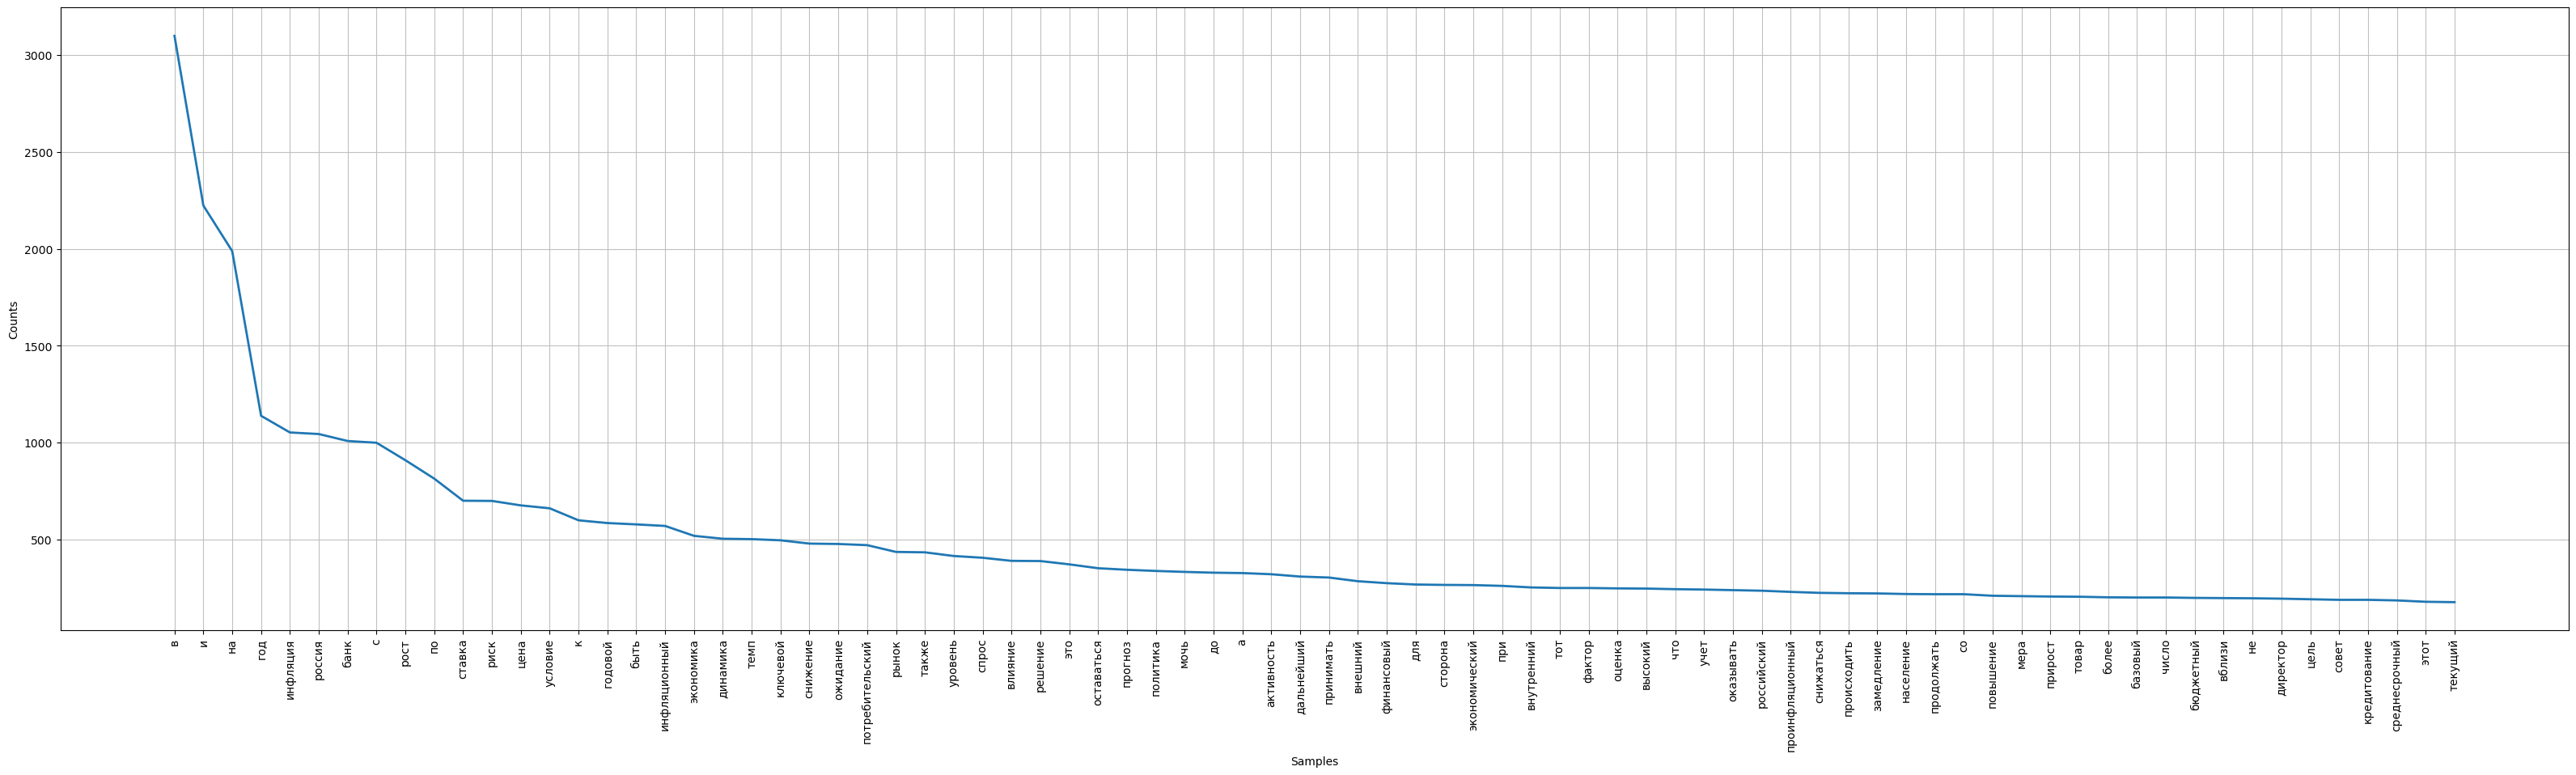

<Axes: xlabel='Samples', ylabel='Counts'>

In [146]:
# 80 наиболее частотных слов
plt.figure(figsize = (40, 10))
fdist.plot(80, cumulative=False)

In [148]:
# удалим стоп-слова и посмотрим, что выйдет
nltk.download("stopwords", quiet=True)
from nltk.corpus import stopwords
russian_stopwords = stopwords.words("russian")

In [150]:
text_stop = [i for i in text if i not in russian_stopwords]

In [152]:
print(len(text), len(text_stop))

65789 50940


In [154]:
import nltk

text_stop = nltk.Text(text_stop)

In [156]:
from nltk.probability import FreqDist
fdist = FreqDist(text_stop)
fdist

FreqDist({'год': 1139, 'инфляция': 1053, 'россия': 1045, 'банк': 1009, 'рост': 910, 'ставка': 701, 'риск': 700, 'цена': 677, 'условие': 662, 'годовой': 586, ...})

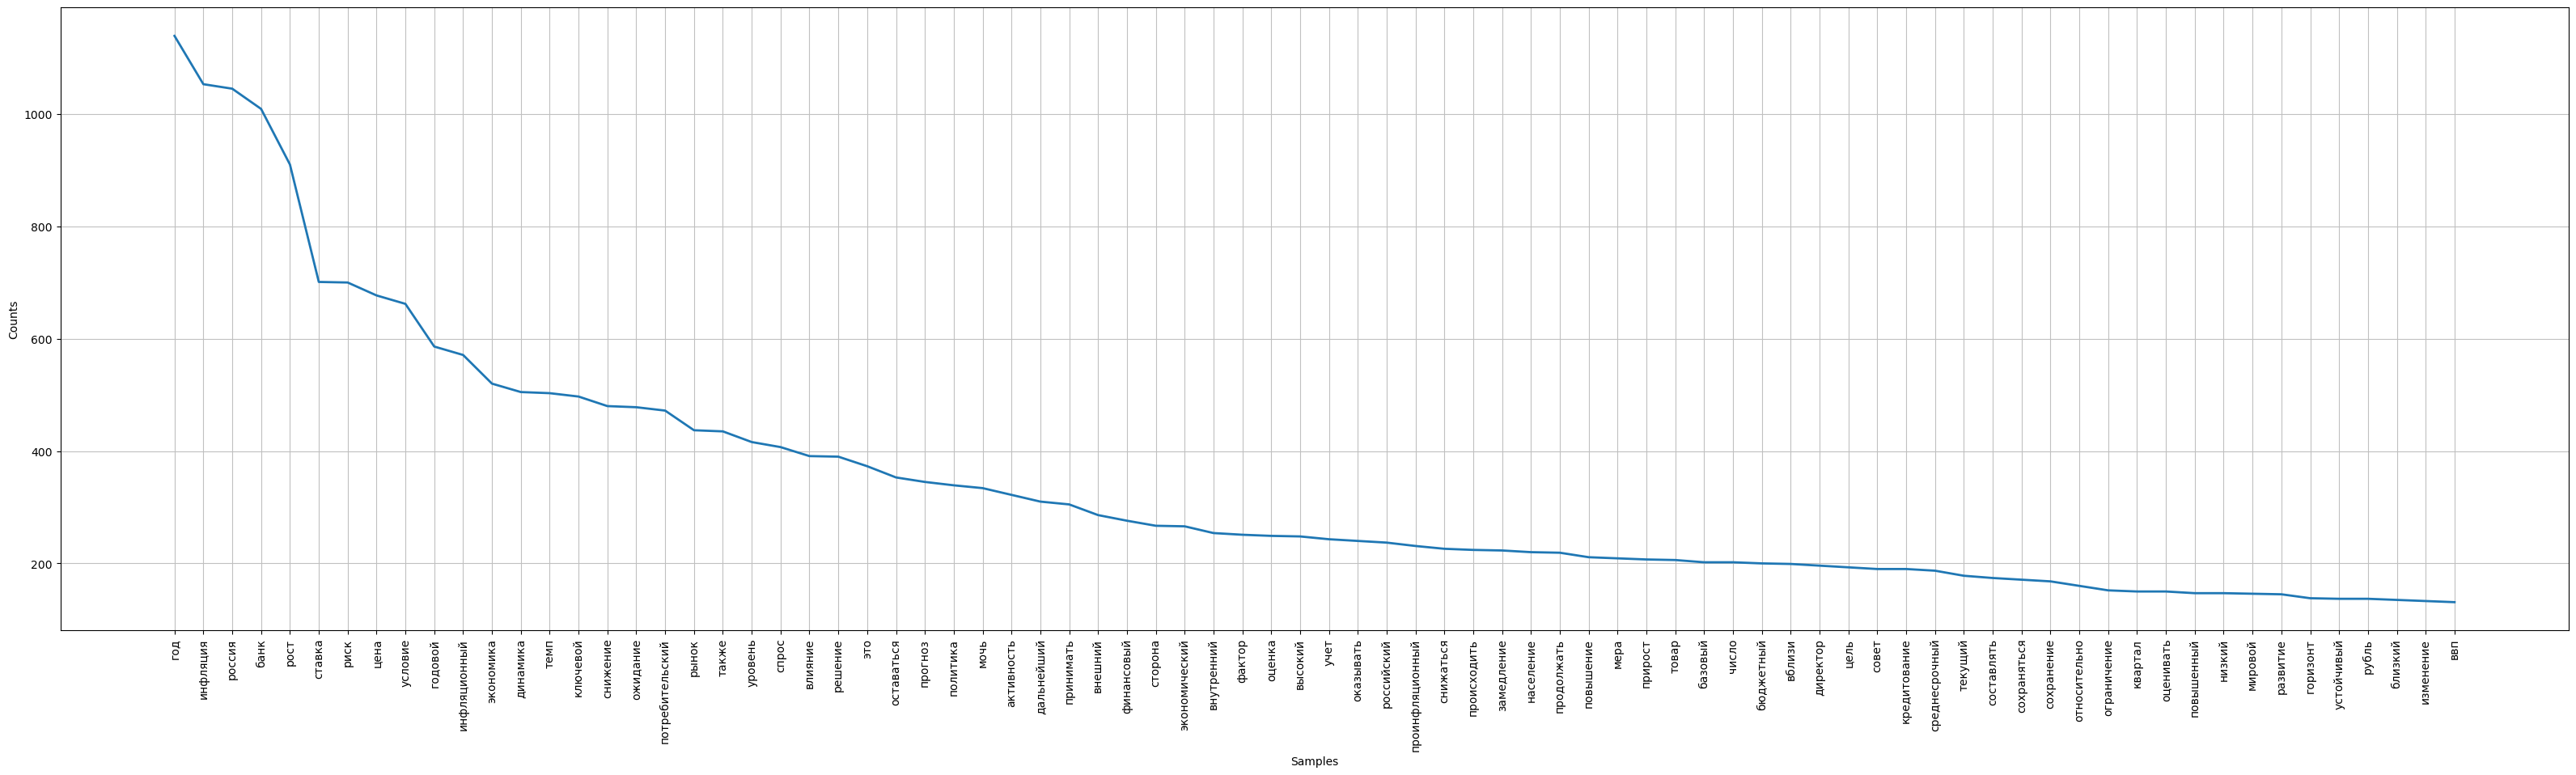

<Axes: xlabel='Samples', ylabel='Counts'>

In [158]:
# 80 наиболее частотных слов после удаления стоп-слов
plt.figure(figsize = (40, 10))
fdist.plot(80,cumulative=False)

### Визуализация популярности слов в виде облака

In [161]:
# pip install wordcloud

In [163]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
# %matplotlib inline

In [165]:
text_raw = " ".join(text_stop)

In [167]:
wordcloud = WordCloud().generate(text_raw)

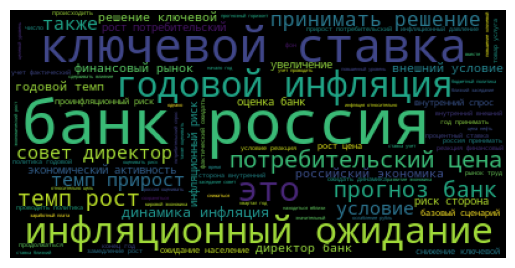

In [169]:
plt.axis('off')
plt.imshow(wordcloud)

### Экспертно расширим список стоп-слов и ещё раз построим облако

In [172]:
# удалим стоп-слова и посмотрим, что выйдет
nltk.download("stopwords", quiet=True)
from nltk.corpus import stopwords
russian_stopwords = stopwords.words("russian")
russian_stopwords.extend(['это', 'совет', 'директор', 'банк', 'россия', 'годовой', 'год'])

text_stop = [i for i in text if i not in russian_stopwords]
print(len(text), len(text_stop))
corpus = text_stop.copy()

65789 46402


In [174]:
import nltk

text_stop = nltk.Text(text_stop)

from nltk.probability import FreqDist
fdist = FreqDist(text_stop)
fdist

FreqDist({'инфляция': 1053, 'рост': 910, 'ставка': 701, 'риск': 700, 'цена': 677, 'условие': 662, 'инфляционный': 571, 'экономика': 520, 'динамика': 505, 'темп': 503, ...})

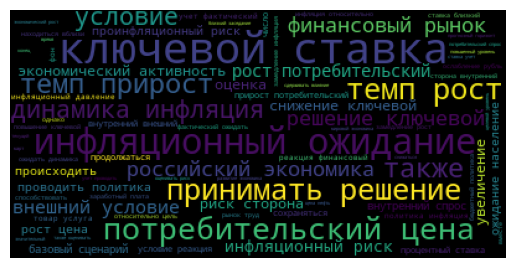

In [176]:
text_raw = " ".join(text_stop)
wordcloud = WordCloud().generate(text_raw)
plt.axis('off')
plt.imshow(wordcloud)

### Морфология. Распределение частей речи.

In [179]:
"""
pip install pymorphy2
pip install pymorphy2-dicts
pip install DAWG-Python

# на питон 3.11 работает только fork pymorphy3

pip install pymorphy3
pip install pymorphy3-dicts-ru
"""

'\npip install pymorphy2\npip install pymorphy2-dicts\npip install DAWG-Python\n\n# на питон 3.11 работает только fork pymorphy3\n\npip install pymorphy3\npip install pymorphy3-dicts-ru\n'

In [181]:
import pymorphy3

In [183]:
texts_tokenized = [i.lower().split() for i in texts_tokenized]

In [185]:
parts_of_speech = dict()

In [187]:
morph = pymorphy3.MorphAnalyzer()

for i in texts_tokenized:
    for j in i:
        p = morph.parse(j)[0]
        p = p.tag.POS
        if p in parts_of_speech:
            parts_of_speech[p]+=1
        else:
            parts_of_speech[p]=1

In [188]:
parts_of_speech

{'NOUN': 29234,
 'VERB': 4630,
 'INFN': 1213,
 'ADJF': 12061,
 'PREP': 10131,
 'ADVB': 1363,
 'CONJ': 3461,
 'NPRO': 637,
 'PRTF': 1139,
 'ADJS': 121,
 'GRND': 227,
 'PRCL': 880,
 'PRTS': 363,
 None: 215,
 'COMP': 72,
 'NUMR': 16,
 'PRED': 26}

In [189]:
parts_of_speech.values()

dict_values([29234, 4630, 1213, 12061, 10131, 1363, 3461, 637, 1139, 121, 227, 880, 363, 215, 72, 16, 26])

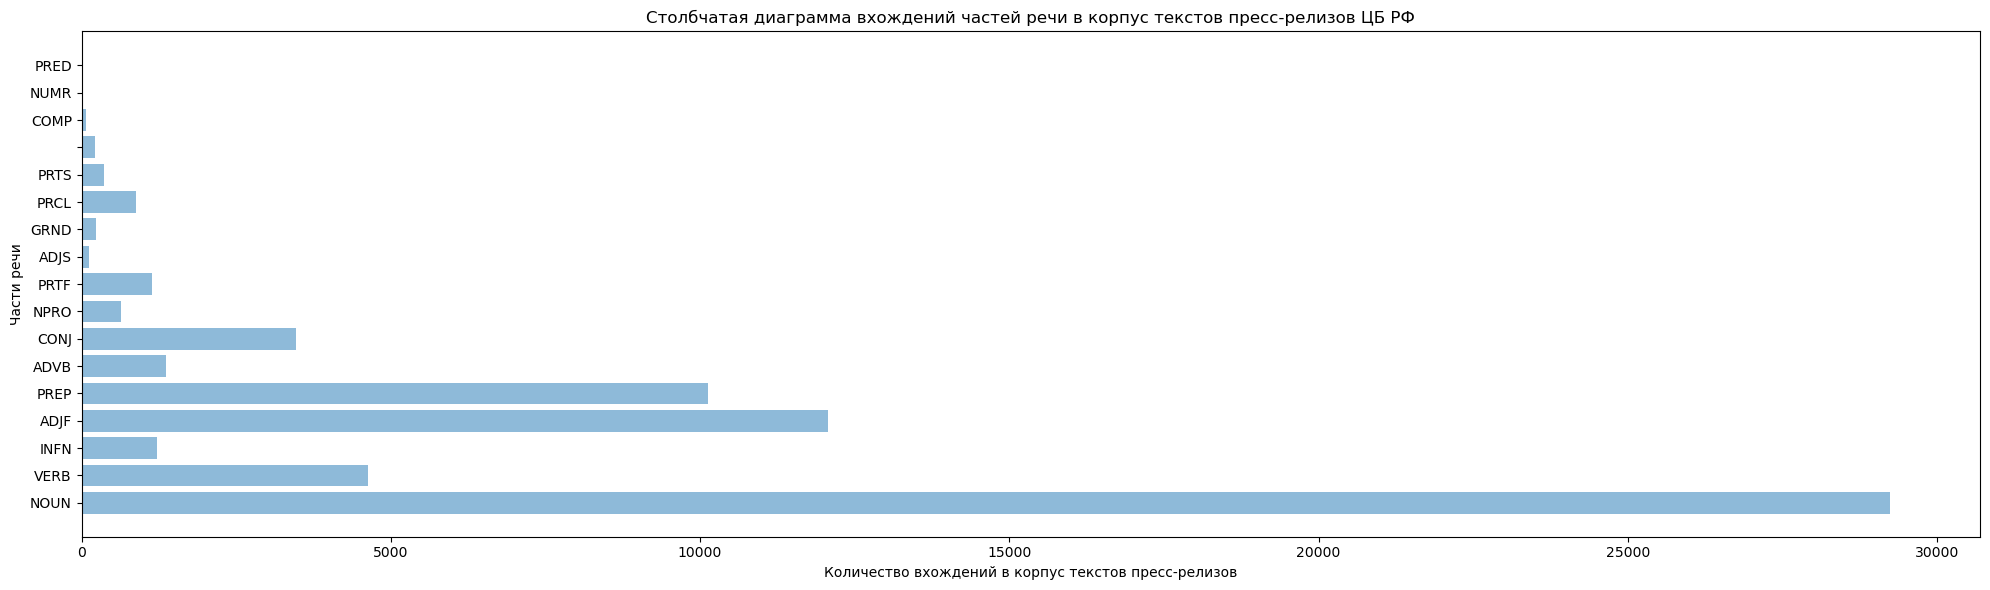

In [190]:
import matplotlib.pyplot as plt
import numpy as np

def plot_parts_of_speech(data):
    speech = data.keys()
    count = data.values()
    y_pos = np.arange(len(speech))
    plt.figure(figsize = (20, 6))
    plt.barh(y_pos, count, align='center', alpha=0.5)
    plt.yticks(y_pos, speech)
    plt.xlabel('Количество вхождений в корпус текстов пресс-релизов')
    plt.ylabel('Части речи')
    plt.title('Столбчатая диаграмма вхождений частей речи в корпус текстов пресс-релизов ЦБ РФ')
    plt.tight_layout()
    plt.show()

plot_parts_of_speech(parts_of_speech)

### TF-IDF

In [192]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vec = TfidfVectorizer()
X = tfidf_vec.fit_transform(texts_lemmatized)

In [193]:
X.toarray()

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.07090139, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.15512583, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.08481149,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.0819686 ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.05661726,
        0.        ]])

In [194]:
pd.DataFrame(X.toarray(), columns=res.keys())

,ii,iii,iv,urals,абсорбирование,август,автомобиль,агент,аграрный,агрегат,...,эпидемия,эпизод,этап,это,этот,эффект,эффективность,юридический,являться,январь
0,0.000000,0.0,0.000000,0.0,0.000000,0.089065,0.000000,0.000000,0.0,0.000000,...,0.0,0.0,0.0,0.056953,0.022163,0.028171,0.0,0.0,0.000000,0.0
1,0.070901,0.0,0.000000,0.0,0.000000,0.119600,0.000000,0.060637,0.0,0.000000,...,0.0,0.0,0.0,0.033991,0.039681,0.025219,0.0,0.0,0.000000,0.0
2,0.155126,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,...,0.0,0.0,0.0,0.000000,0.065114,0.000000,0.0,0.0,0.000000,0.0
3,0.036700,0.0,0.000000,0.0,0.000000,0.000000,0.080953,0.000000,0.0,0.000000,...,0.0,0.0,0.0,0.052783,0.020540,0.000000,0.0,0.0,0.000000,0.0
4,0.000000,0.0,0.049556,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,...,0.0,0.0,0.0,0.062217,0.000000,0.000000,0.0,0.0,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
92,0.000000,0.0,0.045394,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.080164,...,0.0,0.0,0.0,0.075990,0.044355,0.000000,0.0,0.0,0.096531,0.0
93,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,...,0.0,0.0,0.0,0.025367,0.029614,0.000000,0.0,0.0,0.128897,0.0
94,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,...,0.0,0.0,0.0,0.075109,0.000000,0.000000,0.0,0.0,0.084811,0.0
95,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,...,0.0,0.0,0.0,0.072591,0.000000,0.000000,0.0,0.0,0.081969,0.0


### N-gram, извлечение биграмм и триграмм

In [196]:
# Gensim
from numpy import triu
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

In [205]:
#pip install scipy==1.12

In [207]:
#pip install gensim

In [209]:
texts_lemmatized = [i.split() for i in texts_lemmatized]

In [211]:
data_words = texts_tokenized

# строим модели биграмм и триграмм
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)

bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# пример триграммы для первого пресс-релиза
print(trigram_mod[bigram_mod[data_words[0]]])

['совет_директоров', 'банка', 'россии', 'октября', 'года', 'принял_решение', 'повысить_ключевую_ставку', 'на', 'до', 'годовых', 'инфляция', 'складывается', 'существенно', 'выше', 'июльского', 'прогноза', 'банка', 'россии', 'продолжают', 'увеличиваться', 'инфляционные', 'ожидания', 'рост', 'внутреннего', 'спроса', 'значительно', 'опережает_возможности_расширения', 'предложения', 'товаров', 'и', 'услуг', 'дополнительные', 'бюджетные', 'расходы', 'и', 'связанное', 'с', 'этим', 'расширение', 'дефицита', 'федерального_бюджета', 'в', 'году', 'имеют', 'проинфляционные', 'эффекты', 'требуется', 'дальнейшее', 'ужесточение', 'политики', 'для', 'того', 'чтобы', 'обеспечить', 'возвращение', 'инфляции', 'к', 'цели', 'и', 'снизить', 'инфляционные', 'ожидания', 'банк', 'россии', 'допускает_возможность', 'повышения', 'ключевой', 'ставки', 'на', 'ближайшем', 'заседании', 'по', 'прогнозу', 'банка', 'россии', 'с', 'учетом', 'проводимой', 'политики', 'годовая', 'инфляция', 'снизится', 'до', 'в', 'году', '

In [213]:
bigram_mod[data_words[0]] # биграммы для первого пресс-релиза

['совет_директоров',
 'банка',
 'россии',
 'октября',
 'года',
 'принял_решение',
 'повысить_ключевую',
 'ставку',
 'на',
 'до',
 'годовых',
 'инфляция',
 'складывается',
 'существенно',
 'выше',
 'июльского',
 'прогноза',
 'банка',
 'россии',
 'продолжают',
 'увеличиваться',
 'инфляционные',
 'ожидания',
 'рост',
 'внутреннего',
 'спроса',
 'значительно',
 'опережает_возможности',
 'расширения',
 'предложения',
 'товаров',
 'и',
 'услуг',
 'дополнительные',
 'бюджетные',
 'расходы',
 'и',
 'связанное',
 'с',
 'этим',
 'расширение',
 'дефицита',
 'федерального_бюджета',
 'в',
 'году',
 'имеют',
 'проинфляционные',
 'эффекты',
 'требуется',
 'дальнейшее',
 'ужесточение',
 'политики',
 'для',
 'того',
 'чтобы',
 'обеспечить',
 'возвращение',
 'инфляции',
 'к',
 'цели',
 'и',
 'снизить',
 'инфляционные',
 'ожидания',
 'банк',
 'россии',
 'допускает_возможность',
 'повышения',
 'ключевой',
 'ставки',
 'на',
 'ближайшем',
 'заседании',
 'по',
 'прогнозу',
 'банка',
 'россии',
 'с',
 'учетом

## 2. Если у текстов есть метаинформация (дата публикации, авторство и т.д.), то проанализируйте атрибуты, изучите корреляции между этими признаками и текстами.

### Дата пресс-релиза поделена на три колонки:
- year
- month
- day

In [217]:
df['year'].value_counts()

year
2022    11
2014    10
2023     9
2021     8
2020     8
2019     8
2018     8
2017     8
2016     8
2015     8
2024     7
2013     4
Name: count, dtype: int64

### Рассмотрим связь между годом и целевой переменной

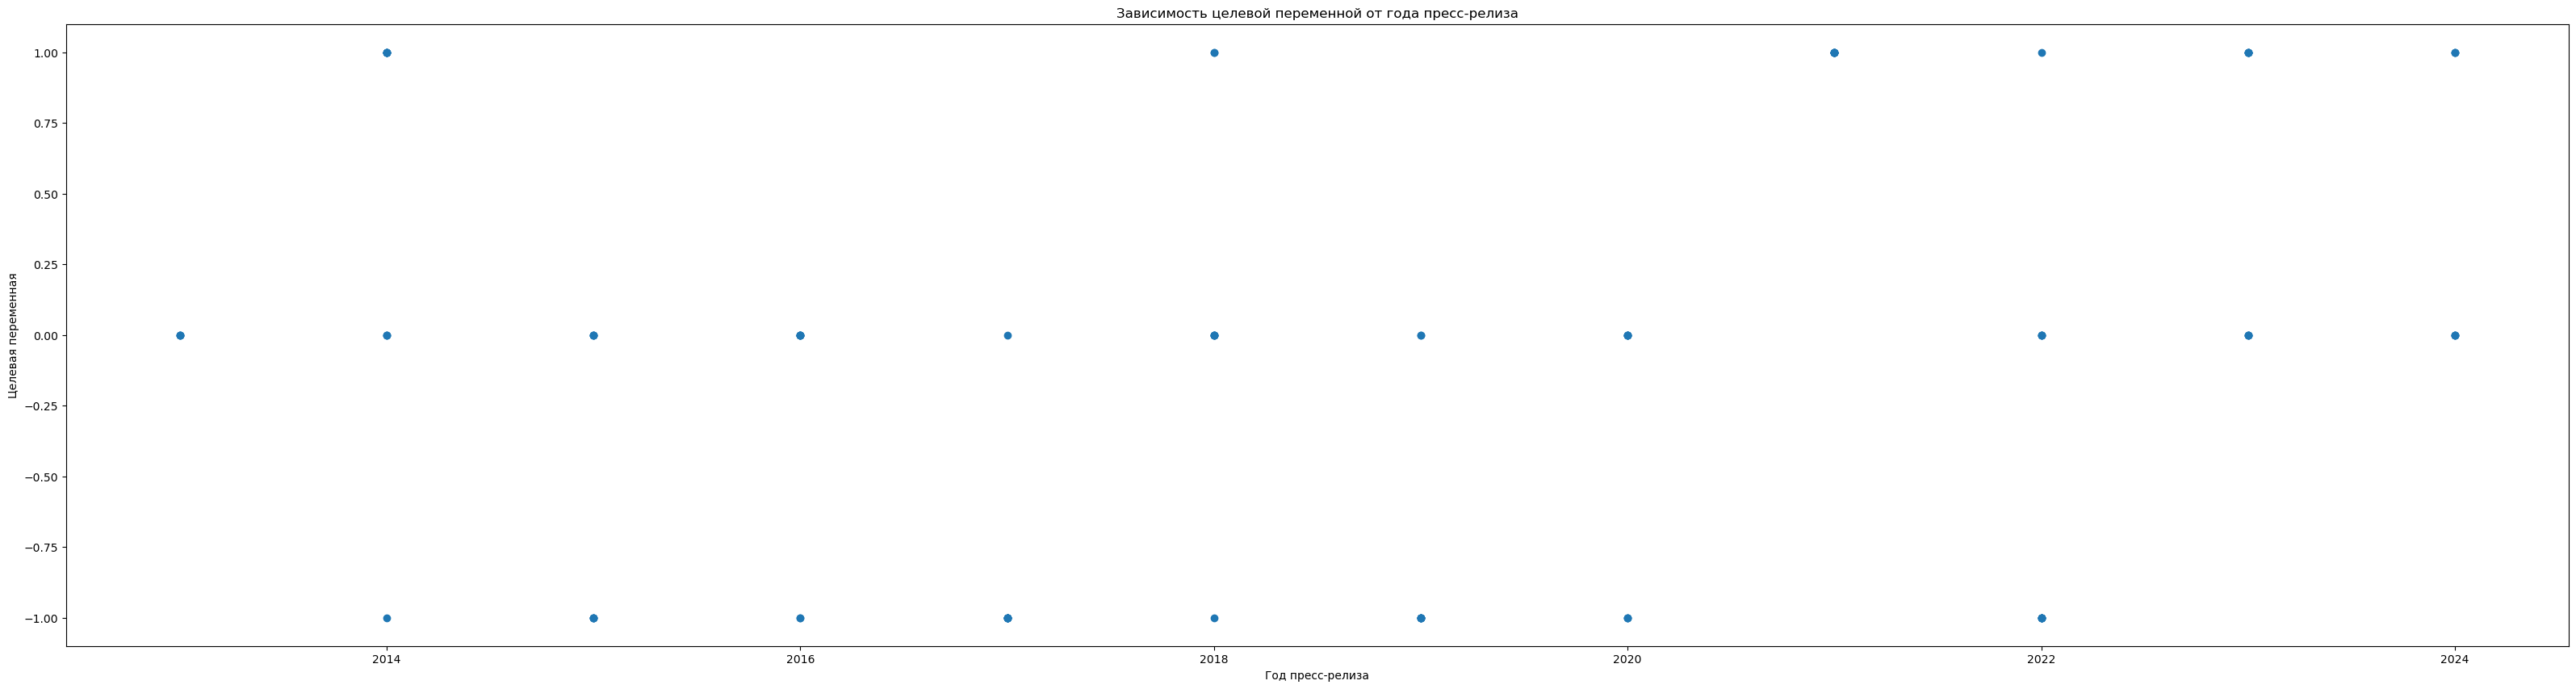

In [220]:
plt.figure(figsize = (40, 10))
plt.title('Зависимость целевой переменной от года пресс-релиза')
plt.xlabel('Год пресс-релиза')
plt.ylabel('Целевая переменная')

plt.scatter(df['year'], df['target'])
plt.show()

### Распределения классов, меток или числовых признаков

In [223]:
df.target.value_counts()

target
0     42
-1    30
1     25
Name: count, dtype: int64

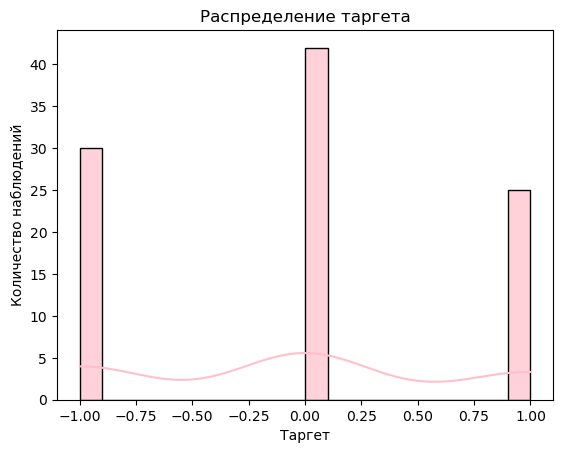

<Figure size 500x4000 with 0 Axes>

In [225]:
sns.histplot(data=df, x='target', bins=20, color='pink', kde=True, alpha=0.7)
plt.title('Распределение таргета')
plt.xlabel('Таргет')
plt.ylabel('Количество наблюдений')
plt.figure(figsize = (5, 40))
plt.show()

# Вывод о структуре данных
#### 1. Средняя длина пресс-релиза: 5695. Минимальная длина пресс-релиза: 320. Максимальная длина пресс-релиза: 9756.
#### 2. Основная проблема данных — их количество. Поскольку пресс-релизы выходят приблизительно раз в один-два месяца, то с 2013 года их собралось менее 100. При обучении модели есть значительная вероятность, что данных не хватит, и тогда датафрейм придётся обогащать макроэкономическими данными.
#### 3. Другая проблема — содержание пресс-релизов. На данном этапе, например, непонятно, достаточно ли данные очищены от стоп-слов. Также зачастую в пресс-релизах вне зависимости от значения таргета встречаются одни и те же слова и словосочетания (выяснили благодаря анализу частотности слов). Возможно, в дальнейшем придётся присваивать веса ряду слов, по которым таргет определится с большей вероятностью. В ходе обучения планируем экспериментировать с данными для улучшения прогнозов :)
#### 4. Из положительных моментов — значения классов в таргете примерно сбалансированы (41, 31, 25 для классов 0, -1, 1 соответственно).

# Check Point 3

## Функция предсказания самого частого класса

In [230]:
df['target'].value_counts()

target
0     42
-1    30
1     25
Name: count, dtype: int64

In [232]:
import random
def predict_top_class(data):    
    return [random.choices([0, -1, 1], weights=[41, 30, 26])[0] for i in range(len(data))]

In [234]:
pd.DataFrame(predict_top_class(df)).value_counts()

0 
 0    38
 1    31
-1    28
Name: count, dtype: int64

In [236]:
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score,
                             fbeta_score, roc_curve, roc_auc_score, precision_recall_curve,
                             auc, average_precision_score, classification_report)

accuracy = accuracy_score(list(df['target']), predict_top_class(df))
error_rate = 1 - accuracy
print(f'Accuracy: {accuracy}')
print(f'Error rate: {error_rate}')

Accuracy: 0.4329896907216495
Error rate: 0.5670103092783505


## Bag of words   

In [240]:
import nltk
from nltk.tokenize import word_tokenize
nltk.download("punkt", quiet=True)

True

In [242]:
# токенизируем тексты (оставим только слова без пунктуации) и склеим списки обратно для лемматизации
texts = df['text']
texts_tokenized = [" ".join([w for w in word_tokenize(t) if w.isalpha()]) for t in texts]

In [244]:
# лемматизируем тексты
from pymystem3 import Mystem

mystem_analyzer = Mystem()
texts_lemmatized = [mystem_analyzer.lemmatize(text) for text in texts_tokenized]
texts_lemmatized = [[j for j in i if j != ' ' and j != '\n'] for i in texts_lemmatized]

In [245]:
texts_lemmatized = [" ".join([w for w in t]) for t in texts_lemmatized]

In [246]:
from nltk.corpus import stopwords
russian_stopwords = stopwords.words("russian")
#russian_stopwords.extend(['это', 'нею'])

In [250]:
# мешок слов
from sklearn.feature_extraction.text import CountVectorizer

cnt_vec = CountVectorizer(stop_words=russian_stopwords)

X_bow = cnt_vec.fit_transform(texts_lemmatized)

In [252]:
df['target'] = df['target'].astype('int') 

In [254]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MaxAbsScaler

In [256]:
x_train, x_test, y_train, y_test = train_test_split(df['text'], df['target'])

In [258]:
x_train = [" ".join([w for w in word_tokenize(t) if w.isalpha()]) for t in x_train]
x_train = [mystem_analyzer.lemmatize(text) for text in x_train]
x_train = [[j for j in i if j != ' ' and j != '\n'] for i in x_train]
x_train = [" ".join([w for w in t]) for t in x_train]


x_test = [" ".join([w for w in word_tokenize(t) if w.isalpha()]) for t in x_test]
x_test = [mystem_analyzer.lemmatize(text) for text in x_test]
x_test = [[j for j in i if j != ' ' and j != '\n'] for i in x_test]
x_test = [" ".join([w for w in t]) for t in x_test]

In [260]:
vec = CountVectorizer(stop_words=russian_stopwords, ngram_range=(1, 1))




In [262]:
bow = vec.fit_transform(x_train)  # bow — bag of words (мешок слов)
bow_test = vec.transform(x_test)

scaler = MaxAbsScaler()
bow = scaler.fit_transform(bow)
bow_test = scaler.transform(bow_test)

In [264]:
clf = LogisticRegression()
clf.fit(bow, y_train)

LogisticRegression()

In [266]:
pred = clf.predict(bow_test)
print("LogisticRegression() на мешке слов")
print(classification_report(y_test, pred))

LogisticRegression() на мешке слов
              precision    recall  f1-score   support

          -1       0.56      1.00      0.71         5
           0       0.67      0.43      0.52        14
           1       0.43      0.50      0.46         6

    accuracy                           0.56        25
   macro avg       0.55      0.64      0.57        25
weighted avg       0.59      0.56      0.55        25



In [268]:
print("Функция предсказания самого частого класса")
print(classification_report(y_test, predict_top_class(y_test)))

Функция предсказания самого частого класса
              precision    recall  f1-score   support

          -1       0.20      0.40      0.27         5
           0       0.33      0.14      0.20        14
           1       0.11      0.17      0.13         6

    accuracy                           0.20        25
   macro avg       0.21      0.24      0.20        25
weighted avg       0.25      0.20      0.20        25



## TF-IDF

In [272]:
from nltk.corpus import stopwords
russian_stopwords = stopwords.words("russian")
#russian_stopwords.extend(['это', 'нею'])
df['target'] = df['target'].astype('int') 

In [274]:
from sklearn.feature_extraction.text import TfidfVectorizer
vec = TfidfVectorizer(stop_words=russian_stopwords, ngram_range=(1, 1))
vec_train = vec.fit_transform(x_train)
vec_test = vec.transform(x_test)

scaler = MaxAbsScaler()
vec_train = scaler.fit_transform(vec_train)
vec_test = scaler.transform(vec_test)

print(type(vec_test))

clf = LogisticRegression(max_iter=300, random_state=42)
clf.fit(vec_train, y_train)
pred_tfidf = clf.predict(vec_test)
print("LogisticRegression() на TF-IDF")
print(classification_report(y_test, pred_tfidf))

<class 'scipy.sparse._csr.csr_matrix'>
LogisticRegression() на TF-IDF
              precision    recall  f1-score   support

          -1       0.50      0.80      0.62         5
           0       0.64      0.50      0.56        14
           1       0.50      0.50      0.50         6

    accuracy                           0.56        25
   macro avg       0.55      0.60      0.56        25
weighted avg       0.58      0.56      0.56        25



## N-GRAM BAG OF WORDS

min_df — при построении словаря будут игнорироваться слова из текстов, частота которых строго ниже заданного порогового значения.
max_df — при построении словаря будут игнорироваться слова из текстов, частота которых строго выше заданного порогового значения.

In [278]:
tfidf = TfidfVectorizer(stop_words=russian_stopwords, min_df=5, max_df=1.0, ngram_range=(1, 3))
tfidf.fit(x_train)

TfidfVectorizer(min_df=5, ngram_range=(1, 3),
                stop_words=['и', 'в', 'во', 'не', 'что', 'он', 'на', 'я', 'с',
                            'со', 'как', 'а', 'то', 'все', 'она', 'так', 'его',
                            'но', 'да', 'ты', 'к', 'у', 'же', 'вы', 'за', 'бы',
                            'по', 'только', 'ее', 'мне', ...])

In [280]:
XtrainNgram = tfidf.transform(x_train)
XtestNgram = tfidf.transform(x_test)

In [282]:
lr_clf = LogisticRegression()
lr_clf.fit(XtrainNgram, y_train)

lr_train_pred = lr_clf.predict(XtrainNgram)
lr_test_pred = lr_clf.predict(XtestNgram)

print("LogisticRegression() на N-GRAM BAG OF WORDS")
print(classification_report(y_test, lr_test_pred))

LogisticRegression() на N-GRAM BAG OF WORDS
              precision    recall  f1-score   support

          -1       0.50      1.00      0.67         5
           0       0.60      0.43      0.50        14
           1       0.40      0.33      0.36         6

    accuracy                           0.52        25
   macro avg       0.50      0.59      0.51        25
weighted avg       0.53      0.52      0.50        25



## Word2Vec

In [285]:
#pip install datasets -q

In [287]:
#pip install pytorch_lightning torchmetrics -q

In [289]:
#pip install joblib

- sentences — массив слов разбитых на слова (список списков токенов).

- vector_size — размерность результирующего embedding вектора.
- min_count — помещать в словарь только слова встретившиеся в тексте более min_count раз.
- window — максимальное расстояние между текущим и предсказанным словом в предложении. В модели word2vec для определения смысловой связи между словами просматриваются соседние слована расстоянии не более window.

In [292]:
sentences = [" ".join([w for w in word_tokenize(t) if w.isalpha()]) for t in df['text']]
sentences = [mystem_analyzer.lemmatize(text) for text in sentences]
sentences = [[j for j in i if j != ' ' and j != '\n'] for i in sentences]
sentences = [" ".join([w for w in t]) for t in sentences]

writers_lines = [[j for j in i.split() if j in corpus] for i in sentences]

In [293]:
import gensim
HIDDEN = 100
model=gensim.models.Word2Vec(sentences = writers_lines, vector_size = HIDDEN, min_count = 1, window = 5)

In [298]:
model.train(x_train, total_examples=model.corpus_count, epochs=30, report_delay=1)

(4470, 11101770)

In [300]:
def get_mean_w2v_vector(sentence):
    Sum = 0
    Count = 0

    try:
      words = sentence.split()
    except TypeError:
      words = []

    for w in words:
        if w in model.wv:
            Sum += model.wv[w]
            # Sum += glove_vectors[w]
            Count += 1

    if Count == 0:
        return 0

    return Sum / Count

In [302]:
NewCols = ['col'+str(i) for i in range(HIDDEN)]

x_train = pd.DataFrame(x_train)
x_test = pd.DataFrame(x_test)


x_train['vectors'] = x_train.map(get_mean_w2v_vector)
x_test['vectors'] = x_test.map(get_mean_w2v_vector)

x_train.head()

,0,vectors
0,совет директор банк россия принимать решение п...,"[0.06861554, 0.21166281, 0.21202143, 0.0877383..."
1,совет директор банк россия сентябрь год приним...,"[0.030431323, 0.25141796, 0.21456073, 0.098467..."
2,совет директор банк россия март год принимать ...,"[0.023893408, 0.26538017, 0.21740861, 0.098769..."
3,совет директор банк россия январь год принимат...,"[-0.007935694, 0.26696587, 0.18495283, 0.09550..."
4,совет директор банк россия март год принимать ...,"[0.018165402, 0.2594035, 0.20467612, 0.0966563..."


In [304]:
# Удалим строки, для которых векторы не посчитались (все слова оказались неизвестными).
IdxTrain = []

for ix, row in x_train.iterrows():
    if not isinstance(row['vectors'],np.ndarray):
        IdxTrain.append(ix)

IdxTest = []

for ix, row in x_test.iterrows():
    if not isinstance(row['vectors'],np.ndarray):
        IdxTest.append(ix)

In [306]:
x_train.drop(index=IdxTrain, inplace=True)
x_test.drop(index=IdxTest, inplace=True)

y_train = y_train.drop(index=IdxTrain)
y_test = y_test.drop(index=IdxTest)

In [308]:
x_train[NewCols] = pd.DataFrame(x_train['vectors'].tolist(), index=x_train.index)
x_test[NewCols] = pd.DataFrame(x_test['vectors'].tolist(), index=x_test.index)

In [310]:
x_train.head()

,0,vectors,col0,col1,col2,col3,col4,col5,col6,col7,...,col90,col91,col92,col93,col94,col95,col96,col97,col98,col99
0,совет директор банк россия принимать решение п...,"[0.06861554, 0.21166281, 0.21202143, 0.0877383...",0.068616,0.211663,0.212021,0.087738,0.061706,-0.464235,0.253864,0.513242,...,0.407749,0.245601,-0.100668,0.067770,0.266542,0.262412,-0.081225,-0.157229,0.203714,-0.177775
1,совет директор банк россия сентябрь год приним...,"[0.030431323, 0.25141796, 0.21456073, 0.098467...",0.030431,0.251418,0.214561,0.098468,0.108293,-0.630641,0.306190,0.611935,...,0.484897,0.324929,-0.123747,0.040571,0.397092,0.311241,-0.063934,-0.238941,0.213868,-0.169769
2,совет директор банк россия март год принимать ...,"[0.023893408, 0.26538017, 0.21740861, 0.098769...",0.023893,0.265380,0.217409,0.098769,0.125229,-0.647577,0.302895,0.642393,...,0.506719,0.339430,-0.122210,0.041574,0.401416,0.330711,-0.080953,-0.237103,0.218994,-0.172662
3,совет директор банк россия январь год принимат...,"[-0.007935694, 0.26696587, 0.18495283, 0.09550...",-0.007936,0.266966,0.184953,0.095507,0.157746,-0.673196,0.270010,0.659657,...,0.507818,0.342365,-0.108077,0.031778,0.419841,0.344866,-0.094303,-0.236640,0.187565,-0.143429
4,совет директор банк россия март год принимать ...,"[0.018165402, 0.2594035, 0.20467612, 0.0966563...",0.018165,0.259403,0.204676,0.096656,0.126771,-0.644147,0.292687,0.639215,...,0.495311,0.327447,-0.114004,0.042984,0.402152,0.328459,-0.079257,-0.234278,0.203201,-0.162544


In [312]:
x_train.drop([0,'vectors'], axis=1, inplace=True)
x_test.drop([0,'vectors'], axis=1, inplace=True)

In [314]:
lr_clf_w2v = LogisticRegression()
lr_clf_w2v.fit(x_train, y_train)

lr_train_pred_w2v = lr_clf_w2v.predict(x_train)
lr_test_pred_w2v = lr_clf_w2v.predict(x_test)

accuracy_score(y_train, lr_train_pred_w2v), accuracy_score(y_test, lr_test_pred_w2v)

(0.4861111111111111, 0.44)

In [316]:
print("LogisticRegression() на word to vec")
print(classification_report(y_test, lr_test_pred_w2v))

LogisticRegression() на word to vec
              precision    recall  f1-score   support

          -1       0.17      0.20      0.18         5
           0       0.53      0.71      0.61        14
           1       0.00      0.00      0.00         6

    accuracy                           0.44        25
   macro avg       0.23      0.30      0.26        25
weighted avg       0.33      0.44      0.38        25



## Pipeline

In [319]:
from sklearn.base import BaseEstimator
class PrepareData(BaseEstimator):
    def __init__(self):
        pass

    def fit(self, x, y):
        return self
         

    def transform(self, x, r = 'train'):

        # токенизируем тексты (оставим только слова без пунктуации) и склеим списки обратно для лемматизации
        texts = x
        texts_tokenized = [" ".join([w for w in word_tokenize(t) if w.isalpha()]) for t in texts]
        
        # лемматизируем тексты
        from pymystem3 import Mystem
        
        mystem_analyzer = Mystem()
        texts_lemmatized = [mystem_analyzer.lemmatize(text) for text in texts_tokenized]
        texts_lemmatized = [[j for j in i if j != ' ' and j != '\n'] for i in texts_lemmatized]
        
        
        texts_lemmatized = [" ".join([w for w in t]) for t in texts_lemmatized]
        x_train =  texts_lemmatized

        if r == 'train':
            vec = TfidfVectorizer(stop_words=russian_stopwords, ngram_range=(1, 1))
            vec_train = vec.fit_transform(x_train)
            self.vec = vec
        else:
            vec_train = self.vec.transform(x_train)
        
        
        if r == 'train':
            self.scaler = MaxAbsScaler()
            vec_train = self.scaler.fit_transform(vec_train)
        else:
            vec_train = self.scaler.transform(vec_train )
  
        
        return vec_train

In [321]:
import pandas as pd
from sklearn.base import BaseEstimator
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, root_mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import TargetEncoder
from sklearn.pipeline import Pipeline

pipeline_final = Pipeline(steps=[
    ('prepare_data',  PrepareData()),
    ('tf-idf', LogisticRegression(max_iter=300, random_state=42))
])

In [323]:
pipeline_final

Pipeline(steps=[('prepare_data', PrepareData()),
                ('tf-idf', LogisticRegression(max_iter=300, random_state=42))])

In [325]:
x_train, x_test, y_train, y_test = train_test_split(df['text'], df['target'])
pipeline_final.fit(x_train, y_train.astype(int))
pipeline_final

Pipeline(steps=[('prepare_data', PrepareData()),
                ('tf-idf', LogisticRegression(max_iter=300, random_state=42))])

In [333]:
# x_test, y_test 
# подготовим тестовые данные
x_test = pipeline_final['prepare_data'].transform(x = x_test, r='test')

In [335]:
pred_tfidf = pipeline_final['tf-idf'].predict(x_test)

In [337]:
print("LogisticRegression() на TF-IDF")
print(classification_report(y_test.astype(int), pred_tfidf))

LogisticRegression() на TF-IDF
              precision    recall  f1-score   support

          -1       0.60      0.43      0.50         7
           0       0.58      0.54      0.56        13
           1       0.50      0.80      0.62         5

    accuracy                           0.56        25
   macro avg       0.56      0.59      0.56        25
weighted avg       0.57      0.56      0.55        25



## ROC-AUC

In [339]:
from sklearn.preprocessing import label_binarize
from sklearn.model_selection import train_test_split
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import roc_curve, auc, RocCurveDisplay
from sklearn.linear_model import LogisticRegression
from sklearn import datasets
from itertools import cycle
import matplotlib.pyplot as plt

**Casus 1**:
Positive class - -1 (ЦБ понизил ставку)
Negative Class - 1 или 0 (ЦБ повысил ставку или оставил без изменений)

**Casus 2**:
Positive class - 0 (ЦБ оставил ставку без изменений)
Negative Class - 1 или -1 (ЦБ повысил или понизил ставку)

**Casus 3**:
Positive class - 1 (ЦБ поднял ставку)
Negative Class - 0 и -1 (ЦБ оставил ставку без изменений или понизил)

In [342]:
# x_train, x_test, y_train, y_test
x_train, x_test, y_train, y_test = train_test_split(df['text'], df['target'])
y_train_new = label_binarize(y_train, classes=[-1, 0, 1])
y_train_new[:5]

array([[0, 0, 1],
       [0, 0, 1],
       [1, 0, 0],
       [0, 1, 0],
       [1, 0, 0]])

In [344]:
y_train[:5]

31    1
2     1
41   -1
35    0
60   -1
Name: target, dtype: int64

In [346]:
y_test_new = label_binarize(y_test, classes=[-1, 0, 1])
y_test_new[:5]

array([[1, 0, 0],
       [0, 1, 0],
       [0, 1, 0],
       [1, 0, 0],
       [0, 1, 0]])

In [348]:
# y_test_new[:,0]  #  оставил без изменения
# y_test_new[:,1]  #  повысил ставку
# y_test_new[:,-1] #  понизил ставку

In [350]:
y_test[:5] # y_test_new[:,0] ---

48   -1
49    0
6     0
23   -1
18    0
Name: target, dtype: int64

### Bag of words ROC-AUC

In [353]:
x_train = [" ".join([w for w in word_tokenize(t) if w.isalpha()]) for t in x_train]
x_train = [mystem_analyzer.lemmatize(text) for text in x_train]
x_train = [[j for j in i if j != ' ' and j != '\n'] for i in x_train]
x_train = [" ".join([w for w in t]) for t in x_train]


x_test = [" ".join([w for w in word_tokenize(t) if w.isalpha()]) for t in x_test]
x_test = [mystem_analyzer.lemmatize(text) for text in x_test]
x_test = [[j for j in i if j != ' ' and j != '\n'] for i in x_test]
x_test = [" ".join([w for w in t]) for t in x_test]


vec = CountVectorizer(stop_words=russian_stopwords, ngram_range=(1, 1))


bow = vec.fit_transform(x_train)  # bow — bag of words (мешок слов)
bow_test = vec.transform(x_test)

scaler = MaxAbsScaler()
bow = scaler.fit_transform(bow)
bow_test = scaler.transform(bow_test)

In [354]:
casus_1 = LogisticRegression(random_state=0)\
    .fit(bow, y_train_new[:, 0])
casus_2 = LogisticRegression(random_state=0)\
    .fit(bow, y_train_new[:, 1])
casus_3 = LogisticRegression(random_state=0)\
    .fit(bow, y_train_new[:, 2])
 
print(f"Model Accuracy :")
print(f"casus 1 - {casus_1.score(bow_test, y_test_new[:, 0])}")
print(f"casus 2 - {casus_2.score(bow_test, y_test_new[:, 1])}")
print(f"casus 3 - {casus_3.score(bow_test, y_test_new[:, 2])}")

Model Accuracy :
casus 1 - 0.76
casus 2 - 0.52
casus 3 - 0.8


In [357]:
model = OneVsRestClassifier(LogisticRegression(random_state=0))\
    .fit(bow , y_train)
prob_test_vec = model.predict_proba(bow_test)
 
n_classes = 3
fpr = [0] * 3
tpr = [0] * 3
thresholds = [0] * 3
auc_score = [0] * 3
 
for i in range(n_classes):
    fpr[i], tpr[i], thresholds[i] = roc_curve(y_test_new[:, i],
                                              prob_test_vec[:, i])
    auc_score[i] = auc(fpr[i], tpr[i])
 
auc_score

[0.7866666666666666, 0.5897435897435898, 0.8695652173913043]

In [359]:
print(f"auc_score Bag of words (среднее значение): {sum(auc_score) / n_classes}")

auc_score Bag of words (среднее значение): 0.7486584912671869


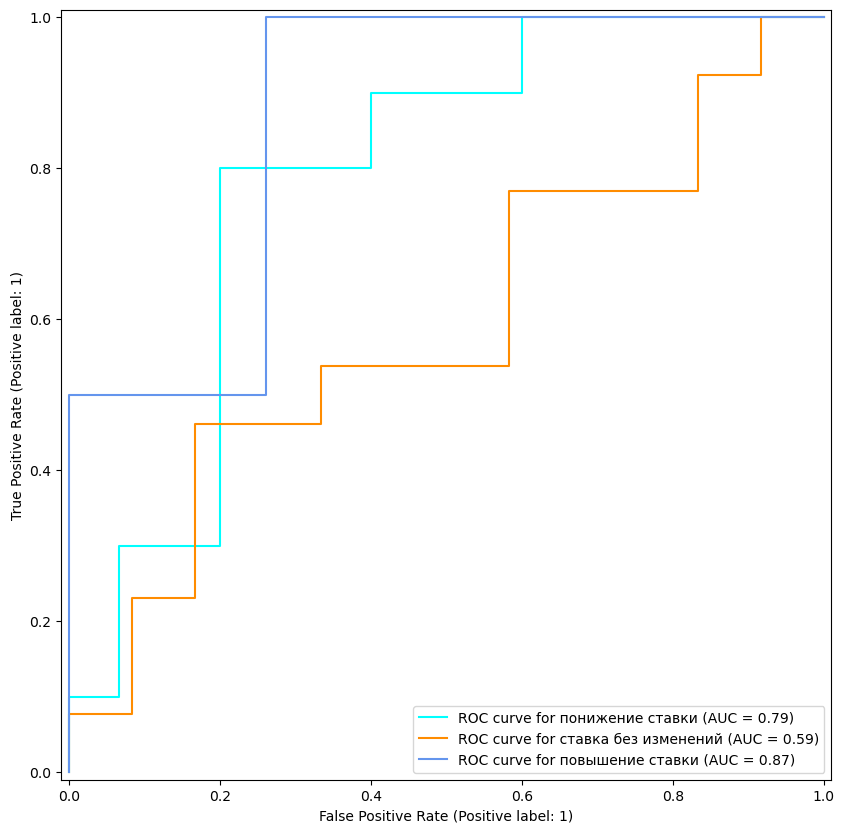

In [361]:
fig, ax = plt.subplots(figsize=(10, 10))
target_names = ['понижение ставки', 'ставка без изменений', 'повышение ставки']
colors = cycle(["aqua", "darkorange", "cornflowerblue"])
for class_id, color in zip(range(n_classes), colors):
    RocCurveDisplay.from_predictions(
        y_test_new[:, class_id],
        prob_test_vec[:, class_id],
        name=f"ROC curve for {target_names[class_id]}",
        color=color,
        ax=ax,
    )

### N-GRAM BAG OF WORDS ROC-AUC

In [386]:
X = df['text']
y = df['target']

X = [" ".join([w for w in word_tokenize(t) if w.isalpha()]) for t in X]
X = [mystem_analyzer.lemmatize(text) for text in X]
X = [[j for j in i if j != ' ' and j != '\n'] for i in X]
X = [" ".join([w for w in t]) for t in X]


In [388]:
# обучим и сериализируем лучшую модель на всех данных
N_GRAM_BOW_TRANSFORMER = TfidfVectorizer(stop_words=russian_stopwords, min_df=5, max_df=1.0, ngram_range=(1, 3))

N_GRAM_BOW_TRANSFORMER.fit(X)

X_NGRAM = N_GRAM_BOW_TRANSFORMER.transform(X)




best_model = LogisticRegression()
best_model.fit(X_NGRAM, y)


pred_X = best_model.predict(X_NGRAM)


print("LogisticRegression() на N-GRAM BAG OF WORDS")
print(classification_report(y, pred_X))

LogisticRegression() на N-GRAM BAG OF WORDS
              precision    recall  f1-score   support

          -1       0.94      0.97      0.95        30
           0       0.87      0.95      0.91        42
           1       1.00      0.80      0.89        25

    accuracy                           0.92        97
   macro avg       0.94      0.91      0.92        97
weighted avg       0.92      0.92      0.92        97



In [400]:
N_GRAM_BOW_TRANSFORMER.transform([wonder['text']])

<1x4405 sparse matrix of type '<class 'numpy.float64'>'
	with 75 stored elements in Compressed Sparse Row format>

In [402]:
best_model.predict(N_GRAM_BOW_TRANSFORMER.transform([wonder['text']]))

array([0])

In [404]:
import joblib

In [406]:
# сохраним лучшую модель
from joblib import dump



dump(N_GRAM_BOW_TRANSFORMER, 'N_GRAM_BOW_TRANSFORMER.joblib')
dump(best_model, 'best_model.joblib')




"""

from joblib import load
N_GRAM_BOW_TRANSFORMER = load('N_GRAM_BOW_TRANSFORMER.joblib')
best_model = load('best_model.joblib')

"""


"\n\nfrom joblib import load\nN_GRAM_BOW_TRANSFORMER = load('N_GRAM_BOW_TRANSFORMER.joblib')\nbest_model = load('best_model.joblib')\n\n"

In [364]:
tfidf = TfidfVectorizer(stop_words=russian_stopwords, min_df=5, max_df=1.0, ngram_range=(1, 3))
tfidf.fit(x_train)

XtrainNgram = tfidf.transform(x_train)
XtestNgram = tfidf.transform(x_test)

In [366]:
casus_1 = LogisticRegression(random_state=0)\
    .fit(XtrainNgram, y_train_new[:, 0])
casus_2 = LogisticRegression(random_state=0)\
    .fit(XtrainNgram, y_train_new[:, 1])
casus_3 = LogisticRegression(random_state=0)\
    .fit(XtrainNgram, y_train_new[:, 2])
 
print(f"Model Accuracy :")
print(f"casus 1 - {casus_1.score(XtestNgram, y_test_new[:, 0])}")
print(f"casus 2 - {casus_2.score(XtestNgram, y_test_new[:, 1])}")
print(f"casus 3 - {casus_3.score(XtestNgram, y_test_new[:, 2])}")

Model Accuracy :
casus 1 - 0.6
casus 2 - 0.52
casus 3 - 0.96


In [368]:
model = OneVsRestClassifier(LogisticRegression(random_state=0))\
    .fit(XtrainNgram , y_train)
prob_test_vec = model.predict_proba(XtestNgram)
 
n_classes = 3
fpr = [0] * 3
tpr = [0] * 3
thresholds = [0] * 3
auc_score = [0] * 3
 
for i in range(n_classes):
    fpr[i], tpr[i], thresholds[i] = roc_curve(y_test_new[:, i],
                                              prob_test_vec[:, i])
    auc_score[i] = auc(fpr[i], tpr[i])
 
auc_score

[0.8200000000000001, 0.5128205128205128, 0.8478260869565217]

In [370]:
print(f"auc_score N-Gram Bag of words (среднее значение): {sum(auc_score) / n_classes}")

auc_score N-Gram Bag of words (среднее значение): 0.7268821999256782


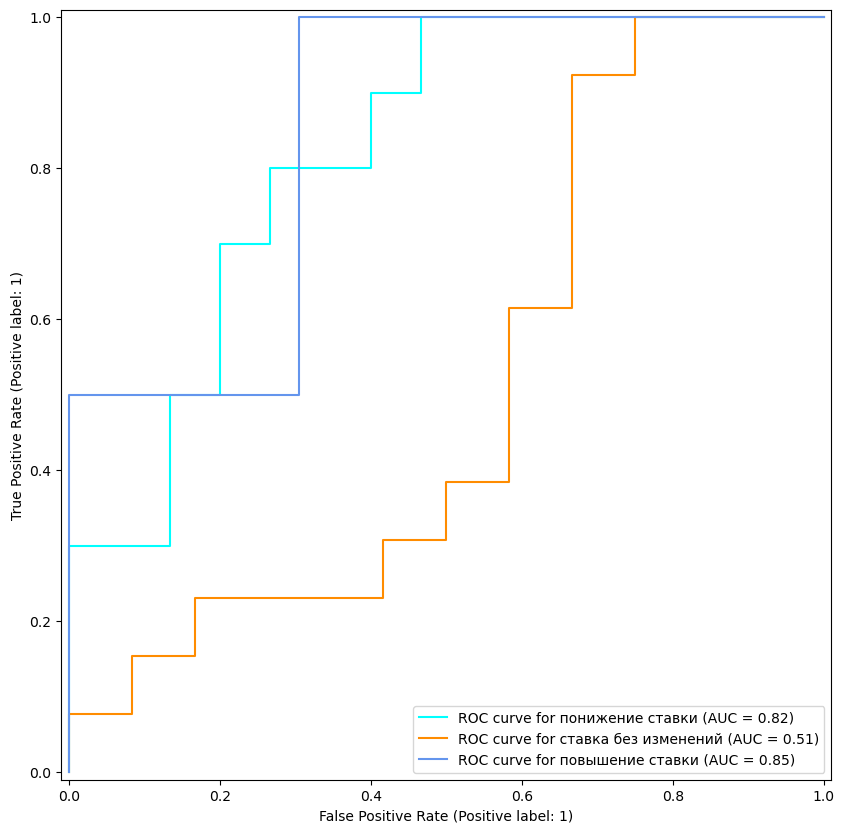

In [372]:
fig, ax = plt.subplots(figsize=(10, 10))
target_names = ['понижение ставки', 'ставка без изменений', 'повышение ставки']
colors = cycle(["aqua", "darkorange", "cornflowerblue"])
for class_id, color in zip(range(n_classes), colors):
    RocCurveDisplay.from_predictions(
        y_test_new[:, class_id],
        prob_test_vec[:, class_id],
        name=f"ROC curve for {target_names[class_id]}",
        color=color,
        ax=ax,
    )

In [408]:
pip freeze > requirements.txt

Note: you may need to restart the kernel to use updated packages.
